In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import model_from_json
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

Using TensorFlow backend.


In [2]:
original_df = pd.read_csv('../data/updated_housing_data.csv').drop('Unnamed: 0', axis = 1).dropna().sort_values(by= 'date', ascending = False)
original_df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,basement_ratio,sqft_living15_ratio,sqft_lot15_ratio,Latitude,Longitude,City,yrs_since_renovation,city_algona,city_auburn,city_baring,city_beaux arts,city_bellevue,city_black diamond,city_bothell,city_burien,city_carnation,city_clyde hill,city_covington,city_des moines,city_duvall,city_enumclaw,city_fall city,city_federal way,city_hunts point,city_issaquah,city_kenmore,city_kent,city_kirkland,city_lake forest park,city_maple valley,city_medina,city_mercer island,city_milton,city_newcastle,city_normandy park,city_north bend,city_pacific,city_preston,city_ravensdale,city_redmond,city_renton,city_sammamish,city_seatac,city_seattle,city_shoreline,city_skykomish,city_snoqualmie,city_snoqualmie pass,city_tukwila,city_vashon,city_woodinville,city_yarrow point,waterfrontness
5425,9/9/2014,385000.0,6,4.0,2700,7416,1.0,0.0,0.0,3,7,1350,1350.0,1969,0.0,98108,47.5525,-122.300,2260,5324,1,0.5,1.195,1.393,47.552513,-122.299896,seattle,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.066815
16623,9/9/2014,180000.0,4,1.0,1470,18581,1.5,0.0,0.0,3,6,1470,0.0,1924,0.0,98055,47.4336,-122.197,1770,18581,0,0.0,0.831,1.000,47.433497,-122.196676,renton,91.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.040288


In [3]:
def get_clean_data(df):
    '''This function will drop data points that are more than 5 SD away'''
    for col in ['price', 'grade', 'bedrooms', 'sqft_living']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mean = df[col].mean()
        std = df[col].std()
        df = df[(df[col] < (mean + 5*std)) & (df[col] > (mean - 5*std))]
    return df

#where to read the csv to use
df = get_clean_data(original_df)
random_state = 0 

df.price = df.price.map(lambda x: x/1000000)

df['living_lot_ratio'] = round(df.sqft_living/df.sqft_lot, 4)
zip_one_hot = pd.get_dummies(df['zipcode'], prefix = 'zip')
df = df.join(zip_one_hot)

cities = [f'city_{i}' for i in df.City.unique()]
zipcodes = [f'zip_{zipc}' for zipc in df.zipcode.unique()]

min_max = MinMaxScaler()
cities = [f'city_{i}' for i in df.City.unique()]
columns = ['waterfront', 'bedrooms', 'sqft_living','living_lot_ratio', 'zipcode', 'bathrooms', 
           'floors'] + cities + zipcodes


X = df[columns]
y = df[['price']]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = random_state, 
                                                    stratify = X.zipcode.values)
x_train = x_train.drop('zipcode', axis = 1)
x_train = min_max.fit_transform(x_train)
x_test = x_test.drop('zipcode', axis = 1)
x_test = min_max.fit_transform(x_test)

/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
print(len(x_train))

17092


In [5]:
def sequential_AAN(x,y, metrics = ['mae']): 
    '''This function creates a sequential NN with 2 hidden layers and returns the model'''
    drop = .4

    model = Sequential()
    
    #input layer
    model.add(Dense(128,input_dim = x.shape[1], activation = 'tanh'))
    model.add(Dropout(drop)) #regularization
    
    #1st hidden layer
    model.add(Dense(64 , activation = 'relu'))
    model.add(Dropout(drop))
    
    #2nd hidden layer
    model.add(Dense(32, activation = 'tanh'))
    model.add(Dropout(drop))  
    
    #output layer
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = metrics)
    return model

In [6]:
epochs = 20
batch = 128 
seq_model = sequential_AAN(x_train, y_train)
seq_history = seq_model.fit(x_train, y_train, epochs = epochs, batch_size = batch, validation_data = (x_test, y_test))

Epoch 1/20
134/134 [==============================] - 1s 4ms/step - loss: 0.1007 - mae: 0.2277 - val_loss: 0.0410 - val_mae: 0.1352
Epoch 2/20
134/134 [==============================] - 0s 3ms/step - loss: 0.0512 - mae: 0.1555 - val_loss: 0.0295 - val_mae: 0.1177
Epoch 3/20
134/134 [==============================] - 0s 3ms/step - loss: 0.0404 - mae: 0.1378 - val_loss: 0.0344 - val_mae: 0.1290
Epoch 4/20
134/134 [==============================] - 0s 3ms/step - loss: 0.0356 - mae: 0.1292 - val_loss: 0.0257 - val_mae: 0.1104
Epoch 5/20
134/134 [==============================] - 0s 2ms/step - loss: 0.0317 - mae: 0.1226 - val_loss: 0.0235 - val_mae: 0.1075
Epoch 6/20
134/134 [==============================] - 0s 2ms/step - loss: 0.0304 - mae: 0.1186 - val_loss: 0.0225 - val_mae: 0.1025
Epoch 7/20
134/134 [==============================] - 0s 3ms/step - loss: 0.0297 - mae: 0.1161 - val_loss: 0.0207 - val_mae: 0.0976
Epoch 8/20
134/134 [==============================] - 0s 2ms/step - loss: 0.

In [7]:
#save model weights

ann_json = seq_model.to_json()
with open('model_weights/ANN_Model.json', 'w') as file:
    file.write(ann_json)
    
seq_model.save('model_weights/ANN_Model_Weights.h5')

Text(0, 0.5, 'Actual (millions)')

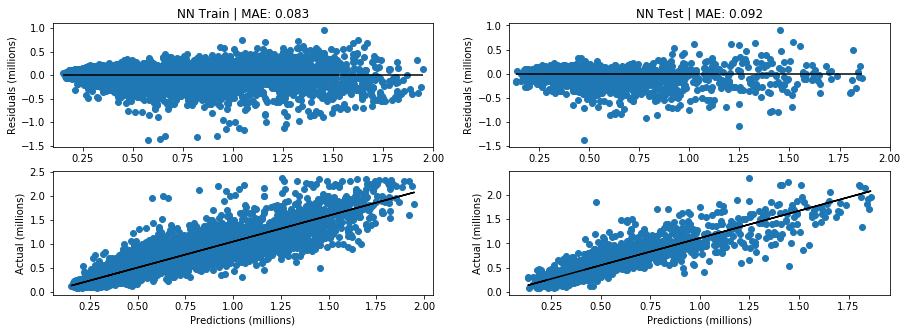

In [8]:
fig, ax = plt.subplots(2,2,figsize = (15,5))
predictions_train = seq_model.predict(x_train)
residuals_train = (predictions_train - y_train)
predictions_test = seq_model.predict(x_test)
residuals_test = predictions_test - y_test
mae_test = round(mean_absolute_error(y_test, predictions_test),3)
mae_train = round(mean_absolute_error(y_train, predictions_train),3)
m_train, b_train = np.polyfit(predictions_train.squeeze(), y_train, 1)
m_test, b_test = np.polyfit(predictions_test.squeeze(), y_test, 1)



ax[0,0].scatter(predictions_train, residuals_train)
ax[0,0].set_title(f'NN Train | MAE: {mae_train}')
ax[0,0].set_ylabel('Residuals (millions)')
ax[0,0].hlines(y = 0, xmin = predictions_train.min(), xmax = predictions_train.max())
ax[0,0].set_xlim(.1,2)


ax[0,1].scatter(predictions_test, residuals_test)
ax[0,1].set_title(f'NN Test | MAE: {mae_test}')
ax[0,1].set_ylabel('Residuals (millions)')
ax[0,1].hlines(y = 0, xmin = predictions_test.min(), xmax = predictions_test.max())
ax[0,1].set_xlim(.1,2)


ax[1,0].scatter(predictions_train, y_train)
ax[1,0].plot(predictions_train, m_train * predictions_train + b_train, color = 'black')
ax[1,0].set_xlabel('Predictions (millions)')
ax[1,0].set_ylabel('Actual (millions)')



ax[1,1].scatter(predictions_test, y_test)
ax[1,1].plot(predictions_test, m_test * predictions_test + b_test, color = 'black')
ax[1,1].set_xlabel('Predictions (millions)')
ax[1,1].set_ylabel('Actual (millions)')


Text(0, 0.5, 'MAE Loss')

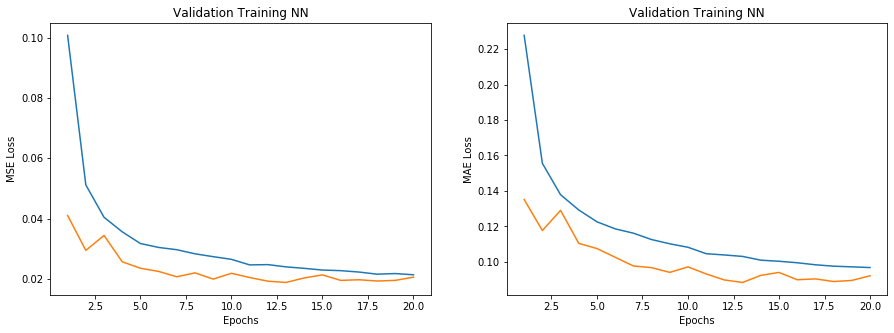

In [9]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
mse_loss = seq_history.history['loss']
mse_val_loss = seq_history.history['val_loss']
epochs = [i for i in range(1, len(mse_loss)+1)]
mae_loss = seq_history.history['mae']
mae_val_loss = seq_history.history['val_mae']

ax[0].plot(epochs, mse_loss, label = 'Training')
ax[0].plot(epochs, mse_val_loss, label = 'Validation')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE Loss')

ax[1].plot(epochs, mae_loss, label = 'Training')
ax[1].plot(epochs, mae_val_loss, label = 'Validation')
ax[1].set_title('Validation Training NN')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('MAE Loss')

### Test on Zillow

In [10]:
def predict_house_value(city, user_zipcode, living_sqft = 0, lot_sqft=0,
                     bedrooms=0, bathrooms=0, floors=0, waterfront = 0): 
    '''This function will calculate the cost of a house in King County WA given the parameters: 
    livig_sqft, lot_sqft, bedrooms, bathrooms, floors, waterfront,city, zipcode'''
    city = city.lower()
    price_chunk = 1000000
    living_lot_ratio = round(living_sqft / lot_sqft, 4)


    
    df= pd.read_csv('../data/updated_housing_data.csv')
    df['living_lot_ratio'] = round(df.sqft_living/df.sqft_lot, 4)


   
    cities = [f'city_{i}' for i in df.City.unique()]
    zipcodes = [f'zip_{zipc}' for zipc in df.zipcode.unique()]
    zip_one_hot = pd.get_dummies(df['zipcode'], prefix = 'zip')
    df = df.join(zip_one_hot)
    columns = ['waterfront', 'bedrooms', 'sqft_living','living_lot_ratio', 'bathrooms', 
           'floors'] + cities + zipcodes
    data = df[columns].values
    min_max = MinMaxScaler().fit(data)
    input_zip = [0 if f'zip_{user_zipcode}' != i else 1 for i in zipcodes]
    input_city = [0 if f'city_{city.lower()}' !=i else 1 for i in cities]
    input_predict = np.array([waterfront, bedrooms,living_sqft, living_lot_ratio, bathrooms, floors]+input_zip+input_city)
    input_predict = min_max.transform(input_predict.reshape(1,-1))
    
    
    json = open('model_weights/ANN_Model.json', 'r')
    ann_json = json.read()
    json.close()
    seq_ann = model_from_json(ann_json)
    seq_ann.load_weights('model_weights/ANN_Model_Weights.h5')
#     house_predict = seq_ann.predict(input_predict.reshape(1, len(input_predict)))
    house_predict = seq_ann.predict(input_predict)[0][0]


    return (house_predict * price_chunk, house_predict/living_sqft * price_chunk)


In [11]:
#example houses from zillow.  Price is adjusted for inflation since 2015

# house = dict(city = 'Seattle', zipcode = '98146', bedrooms = 3, 
#             bathrooms = 4.5, floors = 3, living_sqft = 4070, lot_sqft = 22215.6, waterfront = 1, 
#              actual_price = 3625000 * .92) 

# house = dict(city = 'Seattle', zipcode = '98146', bedrooms = 4, 
#             bathrooms = 3, floors = 3, living_sqft = 2440, lot_sqft = 6969.6, 
#              actual_price = 609000 * .92, waterfront = 0) 

# house = dict(city = 'Fall City', zipcode = '98024', bedrooms = 4, 
#             bathrooms = 2.5, floors = 3, living_sqft = 4145, lot_sqft = 435600, 
#              actual_price = 1675000 * .92, waterfront = 0)

# house = dict(city = 'Seattle', zipcode = '98146', bedrooms = 5, 
#             bathrooms = 5, floors = 3, living_sqft = 3444, lot_sqft = 12632.4, 
#             actual_price = 1488000 * .92, waterfront = 0)

house = dict(city = 'Federal Way', zipcode = '98003', bedrooms = 3, 
        bathrooms = 2.25, floors = 1, living_sqft = 1394, lot_sqft = 9604, 
        actual_price = 363000 * .92, waterfront = 0)


predict = predict_house_value(floors = house['floors'], bedrooms = house['bedrooms'], 
      bathrooms = house['bathrooms'], living_sqft = house['living_sqft'], lot_sqft = house['lot_sqft'], 
      city = house['city'], user_zipcode = house['zipcode'], waterfront = house['waterfront'])

print(f'Predicted Price: ${round(predict[0], 0)} (${round(predict[1],2)} per sqft)\
\nActual Price: ${house["actual_price"]}')

Predicted Price: $227404.0 ($163.13 per sqft)
Actual Price: $333960.0
